# CHAPTER 7: SIGNAL VARIATION 1 - CONDITIONATE YOUR ANALYSIS

A quant with its signal is like a wood sculptor. When working with a signal, you don’t just test random values and **pray for good results**. Like the sculptor, you need to **understand which tools to use** and how to adapt them for your specific goals. If a sculptor has to create a large piece, they may split the work into smaller sections. **That’s exactly what we will do here.**  

We often hear that AI will replace humans, but in reality, we use **simple tools** that require our **critical thinking** to be effective. A great way to enhance these tools is to **conditionate our analysis**. Instead of predicting whether we will hit the Take-Profit or the Stop-Loss for all observations, we will **focus on a specific subset** of observations (e.g., high volatility, RSI > 70, post chart patterns, etc.).  

---

### **Important Notion**  
The code will be **similar to previous examples**, but the focus will be on how to **conditionate your analysis effectively** and avoid errors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
from hurst import compute_Hc
import seaborn as sns
from FeaturesLibrary import *
from Signals import *
from FeaturesSelection import *
sns.set_style("whitegrid")

<br>

### 7.1.1. Features Engineering (Chap 2)

In [2]:
# Import the data
df = pd.read_parquet("DATA/EURUSD_4H_dataset.parquet")[['open', 'high', 'low', 'close', 'tick_volume', 'high_time', 'low_time',
       'hurst', '0_to_20', '20_to_40', '40_to_60', '60_to_80', '80_to_100',
       'linear_slope', 'linear_slope_last_25']].dropna()

In [11]:
# Create many features
df = derivatives(df, "close")
df = DC_market_regime(df, 0.015)
df = spread(df)
df = kama_market_regime(df, "close", 30, 100)
for i in [1, 2, 5, 10, 20, 50]:
    df = auto_corr(df, "close", n=100, lag=i)
for i in [1, 2, 5, 10, 20, 50]:
    df = log_transform(df, "close", i)
df = candle_information(df)
df = moving_yang_zhang_estimator(df, 20)
df['linear_slope_6M'] = df["close"].rolling(125*6).apply(linear_regression_slope_market_trend)
df['linear_slope_3M'] = df["close"].rolling(60*6).apply(linear_regression_slope_market_trend)
df['linear_slope_1M'] = df["close"].rolling(20*6).apply(linear_regression_slope_market_trend)

<br>

### 7.1.2. Target Engineering (Chap 3)

In [12]:
# Create the labels (that will allow us to find the interesting features that are related to them)
df["time"] = df.index
df["high_time"] = df["high_time"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')).astype(str)
df["low_time"] = df["low_time"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')).astype(str)
df["time"] = df["time"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')).astype(str)

df = get_barrier(df, tp=.0050, sl=-.0050, buy=True)

100%|███████████████████████████████████| 15514/15514 [00:13<00:00, 1141.80it/s]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


In [13]:
def dummy_labeling(df):
    df_copy = df.copy()
    
    df_copy["dummy"] = -1
    df_copy.loc[df_copy["labeling"]<0, "dummy"] = 0
    df_copy.loc[0<df_copy["labeling"], "dummy"] = 1
    
    df_copy = df_copy[df_copy["dummy"]!=-1]
    
    return df_copy

df = dummy_labeling(df)

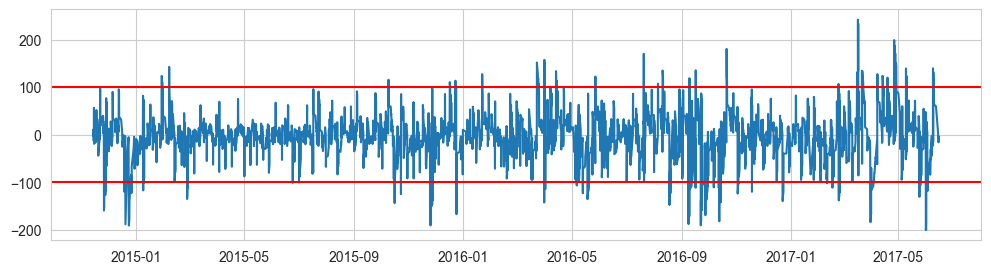

In [14]:
plt.figure(figsize=(12, 3))
plt.plot(df["labeling"].iloc[:4000])
plt.axhline(100, color="red")
plt.axhline(-100, color="red")
plt.show()

### 7.1.3 Conditionate your analysis

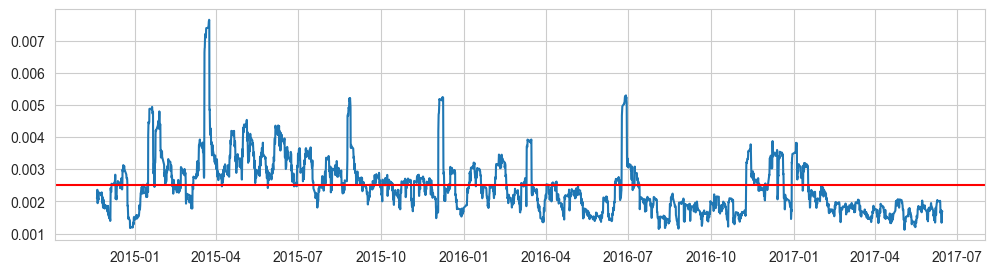

In [16]:
plt.figure(figsize=(12, 3))
plt.plot(df["rolling_volatility_yang_zhang"].iloc[:4000])
plt.axhline(0.0025, color="red")
plt.show()

In [17]:
dfc = df.dropna().iloc[:6000]
dfc = dfc.loc[(0.0025 < dfc["rolling_volatility_yang_zhang"])]
len(dfc)

1188

<br>

### 7.1.4 Features Selection (Chap 4)

In [18]:
list_X = ['hurst', '0_to_20', '20_to_40', '40_to_60', '60_to_80', '80_to_100',
    'velocity', 'acceleration',
       'market_regime', 'spread', 'kama_diff',
       'kama_trend', 'autocorr_1', 'autocorr_2', 'autocorr_5',
       'autocorr_10', 'autocorr_20', 'autocorr_50', 'ret_log_1',
       'ret_log_2', 'ret_log_5', 'ret_log_10', 'ret_log_20', 'ret_log_50',
       'candle_way', 'filling', 'amplitude', 'rolling_volatility_yang_zhang',
         'linear_slope_6M', 'linear_slope_3M', 'linear_slope_1M']
col_y = "dummy"

# Remove the Nan values
df_clean = dfc[list_X + [col_y]].dropna()

# Split our data into features and target
X_train = df_clean.iloc[0:900,:][list_X]
y_train = df_clean.iloc[0:900,:][col_y]

# Standardize the data before selecting the features 
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)

# Keep a train set with the features name (essential for the selection)
X_train_sc_df = pd.DataFrame(X_train_sc, columns=X_train.columns, index=X_train.index)

In [19]:
y_train

time
2015-05-12 04:00:00    1
2015-05-12 08:00:00    0
2015-05-12 12:00:00    1
2015-05-12 16:00:00    1
2015-05-12 20:00:00    1
                      ..
2016-07-04 20:00:00    0
2016-07-05 00:00:00    0
2016-07-05 04:00:00    1
2016-07-05 08:00:00    0
2016-07-05 12:00:00    0
Name: dummy, Length: 900, dtype: int64

In [20]:
vif_results_clean = remove_intercolinarity(X_train_sc_df)
vif_results_clean.index

Index(['hurst', '0_to_20', '20_to_40', '60_to_80', '80_to_100', 'acceleration',
       'market_regime', 'spread', 'kama_diff', 'kama_trend', 'autocorr_1',
       'autocorr_5', 'autocorr_10', 'autocorr_20', 'autocorr_50', 'ret_log_2',
       'ret_log_5', 'ret_log_10', 'ret_log_20', 'ret_log_50', 'candle_way',
       'filling', 'amplitude', 'rolling_volatility_yang_zhang',
       'linear_slope_6M', 'linear_slope_3M', 'linear_slope_1M'],
      dtype='object', name='Feature')

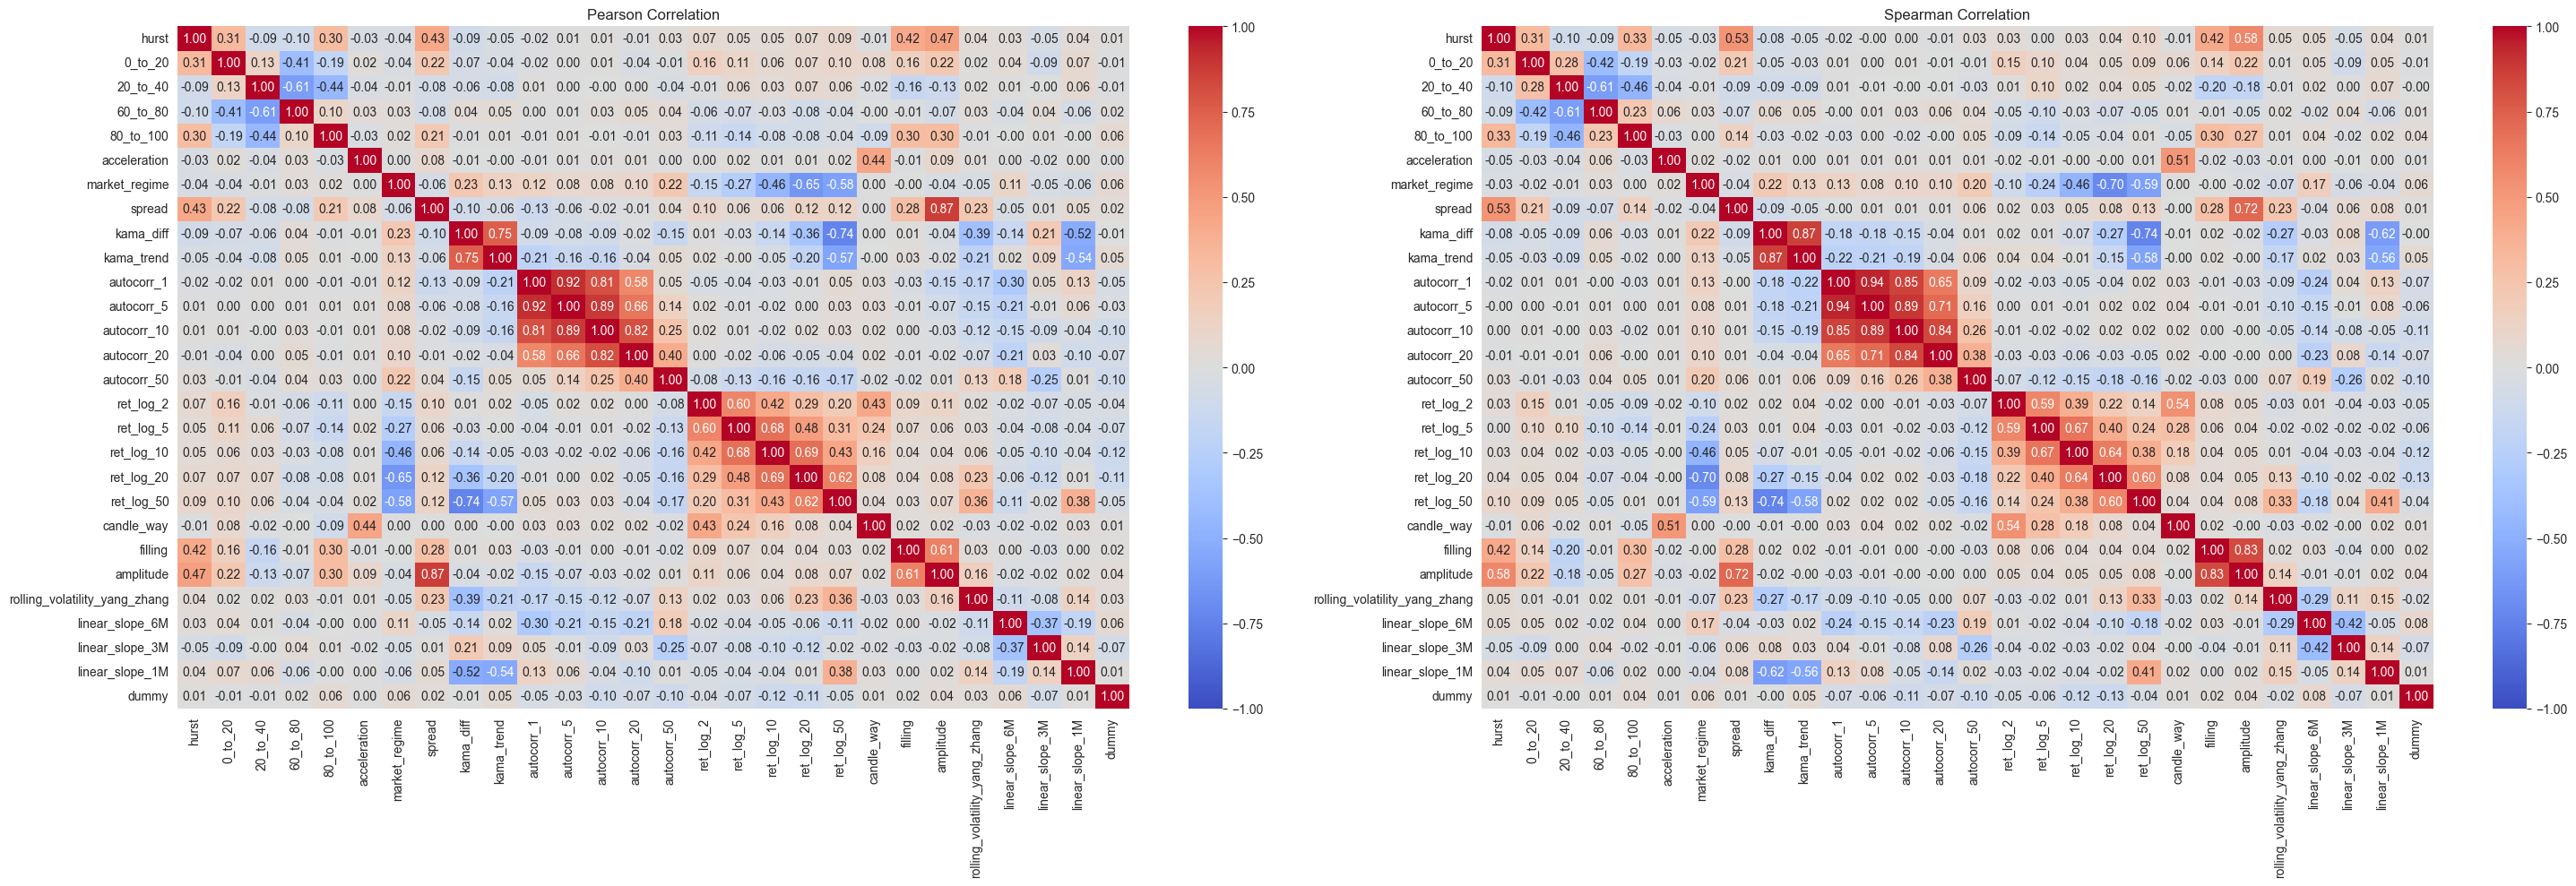

In [21]:
df_train = pd.concat((X_train_sc_df[vif_results_clean.index], y_train), axis=1)
correlation_graphs(df_train)

In [22]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

# For a dummy variable (classification)
mi_scores = mutual_info_classif(X_train_sc_df, y_train)
mi_df = pd.DataFrame({'Feature': X_train_sc_df.columns, 'Mutual Information': mi_scores}).sort_values(by='Mutual Information', ascending=False)
mi_df = mi_df.set_index("Feature")


# Summarize the info
linear_correlation_target = df_train.corr()["dummy"]*100
linear_correlation_target.name = "lr_dummy"

nonlinear_correlation_target = df_train.corr(method="spearman")["dummy"]*100
nonlinear_correlation_target.name = "nlr_dummy"
df_mi_vif = pd.concat((vif_results_clean, mi_df, linear_correlation_target, nonlinear_correlation_target), axis=1).dropna()
df_mi_vif.sort_values("Mutual Information", ascending=False).dropna()

,VIF,Mutual Information,lr_dummy,nlr_dummy
linear_slope_6M,1.90,0.201256,6.192690,7.956383
linear_slope_3M,1.49,0.101480,-7.197507,-6.763118
autocorr_10,10.10,0.063659,-9.560187,-10.633744
autocorr_1,8.90,0.054470,-4.961919,-6.934195
rolling_volatility_yang_zhang,1.61,0.053680,2.682076,-1.922482
autocorr_5,11.22,0.052670,-2.522054,-6.002679
linear_slope_1M,2.06,0.029717,0.916859,1.345096
ret_log_20,3.29,0.027218,-11.452106,-12.514740
amplitude,11.60,0.027066,3.598140,3.594764
candle_way,1.66,0.022159,0.866894,0.866894


In [23]:
df_filtered = df_mi_vif[
    (df_mi_vif['Mutual Information'] > 0.01) |
    (df_mi_vif['lr_dummy'].abs() > 10) |
    (df_mi_vif['nlr_dummy'].abs() > 10)
]

# Afficher le résultat
df_filtered

,VIF,Mutual Information,lr_dummy,nlr_dummy
hurst,1.61,0.016780,1.412577,1.083348
0_to_20,1.63,0.010829,-0.988012,-1.286569
20_to_40,2.28,0.016850,-0.980218,-0.402041
autocorr_1,8.90,0.054470,-4.961919,-6.934195
autocorr_5,11.22,0.052670,-2.522054,-6.002679
autocorr_10,10.10,0.063659,-9.560187,-10.633744
autocorr_50,1.90,0.010971,-10.367503,-10.442138
ret_log_2,2.03,0.013744,-3.783703,-5.333766
ret_log_5,2.56,0.012243,-7.472386,-5.705004
ret_log_10,2.88,0.000000,-12.039548,-11.742326


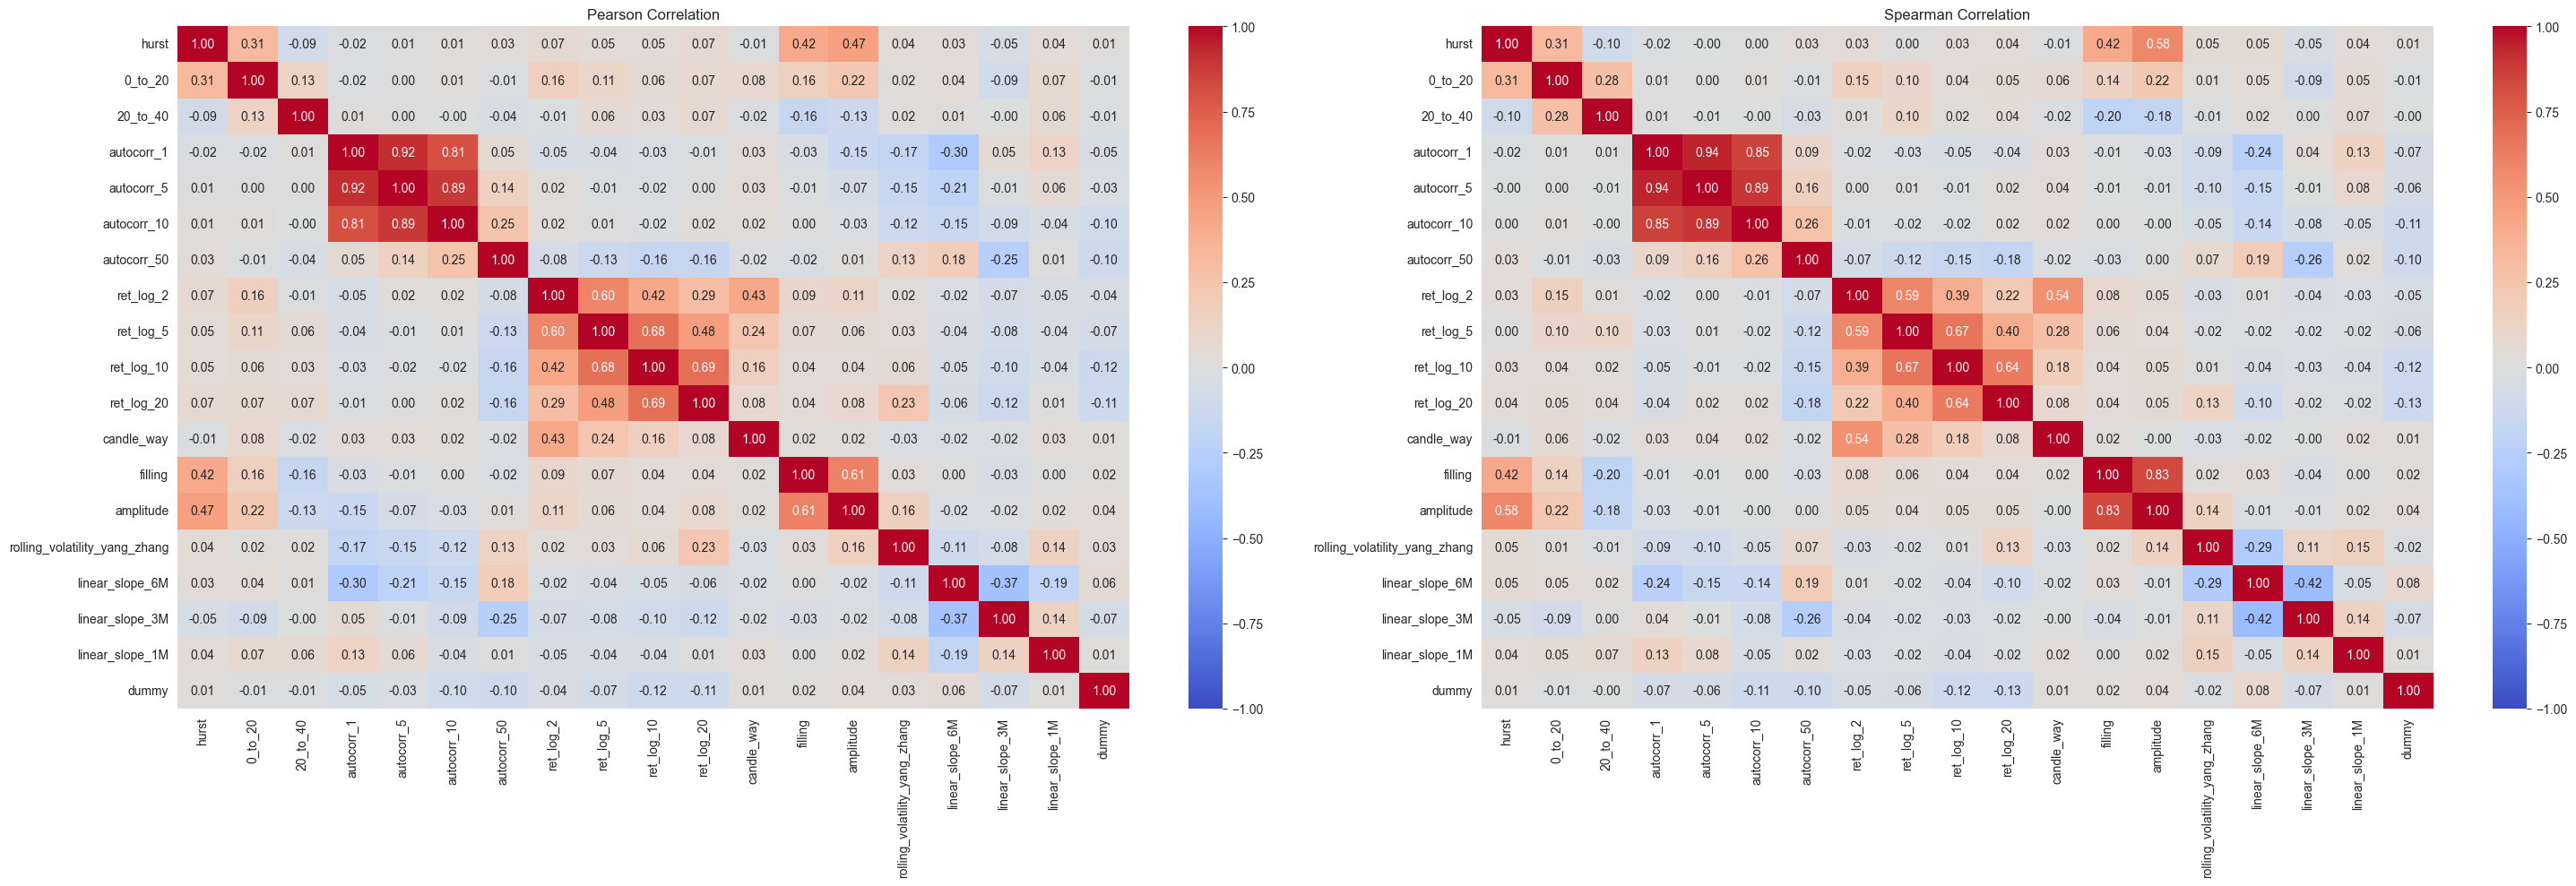

In [24]:
df_train_bis = pd.concat((X_train_sc_df[df_filtered.index], y_train), axis=1)
correlation_graphs(df_train_bis)

In [26]:
df_filtered.index

Index(['hurst', '0_to_20', '20_to_40', 'autocorr_1', 'autocorr_5',
       'autocorr_10', 'autocorr_50', 'ret_log_2', 'ret_log_5', 'ret_log_10',
       'ret_log_20', 'candle_way', 'filling', 'amplitude',
       'rolling_volatility_yang_zhang', 'linear_slope_6M', 'linear_slope_3M',
       'linear_slope_1M'],
      dtype='object')

<br>

### 7.1.5 MODELS (Chap 5)

In [28]:
list_X = ['hurst', '0_to_20', '20_to_40', 
       'autocorr_10', 'autocorr_50', 'ret_log_10',
       'candle_way', 'filling',
       'rolling_volatility_yang_zhang', 'linear_slope_6M', 'linear_slope_3M',
       'linear_slope_1M']
col_y = "dummy"

# Remove the Nan values
df_clean = dfc[list_X + [col_y]].dropna()

# Split our data into features and target
X_train = df_clean.iloc[0:900,:][list_X]
y_train = df_clean.iloc[0:900,:][col_y]

X_test = df_clean.iloc[900:1200,:][list_X]
y_test = df_clean.iloc[900:1200,:][col_y]

# Standardize the data before selecting the features 
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test) # WE DO NOT FIT THE MODEL ON THE TEST DATA ONLY ON THE TRAIN DATA

# Keep a train set with the features name (essential for the selection)
X_train_sc_df = pd.DataFrame(X_train_sc, columns=X_train.columns, index=X_train.index)
X_test_sc_df = pd.DataFrame(X_test_sc, columns=X_test.columns, index=X_test.index)

In [29]:
from sklearn.metrics import confusion_matrix


def model_output_overview(model_class, X_train_sc=X_train_sc, X_test_sc=X_test_sc, y_train=y_train, y_test=y_test):
    model = model_class.fit(X_train_sc, y_train.values)
    y_pred = model.predict(X_test_sc)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    precision_class_0 = 100 * conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0])
    precision_class_1 = 100 * conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])

    print(f"Precision Class 0: {precision_class_0:.2f} % \t Precision Class 1: {precision_class_1:.2f} %")

    print(f"NB Prediction Class 0: {(conf_matrix[0][0] + conf_matrix[1][0])} \t NB Prediction Class 1: {(conf_matrix[1][1] + conf_matrix[0][1])}")

In [30]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression, LinearRegression
model_output_overview(LogisticRegression())

Precision Class 0: 40.70 % 	 Precision Class 1: 47.52 %
NB Prediction Class 0: 86 	 NB Prediction Class 1: 202


In [31]:
# LINEAR SVC
from sklearn.svm import LinearSVC, LinearSVR
model_output_overview(LinearSVC(max_iter=10_000))

Precision Class 0: 40.70 % 	 Precision Class 1: 47.52 %
NB Prediction Class 0: 86 	 NB Prediction Class 1: 202


In [32]:
# NON LINEAR SVC
from sklearn.svm import SVC, SVR
model_output_overview(SVC(C=3))

Precision Class 0: 45.19 % 	 Precision Class 1: 48.91 %
NB Prediction Class 0: 104 	 NB Prediction Class 1: 184


In [33]:
# STANDARD RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
model_output_overview(RandomForestClassifier(n_estimators=100, max_depth=None, random_state=56))

Precision Class 0: 45.87 % 	 Precision Class 1: 49.16 %
NB Prediction Class 0: 109 	 NB Prediction Class 1: 179


In [34]:
# Extra Tree
from sklearn.ensemble import ExtraTreesClassifier
model_class = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=56)
model_output_overview(model_class)

Precision Class 0: 44.21 % 	 Precision Class 1: 48.70 %
NB Prediction Class 0: 95 	 NB Prediction Class 1: 193


In [35]:
from sklearn.ensemble import BaggingClassifier
model_output_overview(BaggingClassifier(estimator=SVC(C=3),
                        n_estimators=10, random_state=56))

Precision Class 0: 44.44 % 	 Precision Class 1: 48.33 %
NB Prediction Class 0: 108 	 NB Prediction Class 1: 180


In [36]:
from sklearn.ensemble import VotingClassifier, VotingRegressor

model_class = VotingClassifier(
    estimators=[('lr', LogisticRegression()),
                ('linsvc', LinearSVC(max_iter=10_000)),
                ('svc', SVC(C=3)),
                ('rfc', RandomForestClassifier(n_estimators=1_000, max_depth=None, random_state=56)),
               ('ext', ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=56)),
               ('bagsvc',BaggingClassifier(estimator=SVC(C=3),n_estimators=10, random_state=56))], voting='hard')

model_output_overview(model_class)

Precision Class 0: 46.49 % 	 Precision Class 1: 49.43 %
NB Prediction Class 0: 114 	 NB Prediction Class 1: 174


In [37]:
# Very quick overview about the profit (only when it is possible which is not always the case)
precision = 0.49
nb_trade = 174
(precision * 0.0048 - 0.0052 * (1-precision)) * nb_trade * 100 # in 8 months

-5.219999999999998

<br>

### 7.1.6. Cross Validation

In [38]:
from sklearn.metrics import make_scorer, confusion_matrix, precision_score

# Function to calculate negative precision
def negative_precision_score(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    TN = conf_matrix[0][0]  # True Negatives
    FN = conf_matrix[1][0]  # False Negatives
    # Avoid division by zero
    if TN + FN == 0:
        return 0
    return TN / (TN + FN)

# Define custom scorers
def count_predictions_0(y_true, y_pred):
    return np.sum(y_pred == 0)  # Count predictions for class 0

def count_predictions_1(y_true, y_pred):
    return np.sum(y_pred == 1)  # Count predictions for class 1

count_0 = make_scorer(count_predictions_0)

# Create scorers
count_0 = make_scorer(count_predictions_0)
count_1 = make_scorer(count_predictions_1)

negative_precision_scorer = make_scorer(negative_precision_score)
positive_precision_scorer = make_scorer(precision_score, pos_label=1)

In [39]:
from sklearn.model_selection import KFold, cross_validate, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Create a pipeline with the scaler and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model_class)
])

# Define scoring metrics
scoring = {
    'positive_precision': positive_precision_scorer,  # Precision for the positive class
    'negative_precision': negative_precision_scorer,  # Precision for the negative class
    'count_pred_0': make_scorer(count_predictions_0), # Count predictions for class 0
    'count_pred_1': make_scorer(count_predictions_1)  # Count predictions for class 1
}

X = pd.concat((X_train, X_test), axis=0)
y = pd.concat((y_train, y_test), axis=0)

# Perform cross-validation with the pipeline
results = cross_validate(pipeline, X, y, cv=tscv, scoring=scoring)

# Display results
print("Positive Precision Scores:", results['test_positive_precision'])
print("Predictions for Class 1:", results['test_count_pred_1'])

print("Negative Precision Scores:", results['test_negative_precision'])
print("Predictions for Class 0:", results['test_count_pred_0'])


print("Mean Positive Precision:", results['test_positive_precision'].mean())
print("Mean Negative Precision:", results['test_negative_precision'].mean())

Positive Precision Scores: [0.43113772 0.32692308 0.32142857 0.49       0.55284553]
Predictions for Class 1: [167  52  28 100 123]
Negative Precision Scores: [0.58064516 0.32876712 0.42352941 0.54081633 0.42666667]
Predictions for Class 0: [ 31 146 170  98  75]
Mean Positive Precision: 0.4244669802715662
Mean Negative Precision: 0.4600849379079957


In [40]:
# K-Fold cross-validation with 10 splits, no shuffling
kf = KFold(n_splits=10, shuffle=False)

# Perform cross-validation with the pipeline
results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring)

# Display results
print("Positive Precision Scores:", results['test_positive_precision'])
print("Predictions for Class 1:", results['test_count_pred_1'])

print("Negative Precision Scores:", results['test_negative_precision'])
print("Predictions for Class 0:", results['test_count_pred_0'])


print("Mean Positive Precision:", results['test_positive_precision'].mean())
print("Mean Negative Precision:", results['test_negative_precision'].mean())

Positive Precision Scores: [0.29166667 0.34848485 0.43396226 0.58108108 0.51282051 0.86206897
 0.35714286 0.46153846 0.48571429 0.725     ]
Predictions for Class 1: [24 66 53 74 78 29 42 65 70 40]
Negative Precision Scores: [0.47368421 0.52830189 0.51515152 0.42222222 0.46341463 0.4
 0.55844156 0.48148148 0.72916667 0.37179487]
Predictions for Class 0: [95 53 66 45 41 90 77 54 48 78]
Mean Positive Precision: 0.5059479943116898
Mean Negative Precision: 0.49436590472234254


In [41]:
np.sum(results['test_positive_precision'] * results['test_count_pred_1']) / np.sum(results['test_count_pred_1'])

0.49722735674676527

In [42]:
np.sum(results['test_negative_precision'] * results['test_count_pred_0']) / np.sum(results['test_count_pred_0'])

0.4853168469860896

With an **R ratio of 0.92** including costs (**0.0048/0.0052**), we need a **52% win rate** to break even. However, it is clear that this signal does not provide enough information to make it interesting or profitable. We can keep the structure, these features, and this target for another signal, but we should **not combine them in the same way**.

---

### **Areas for Improvement**
- **Optimize the target thresholds**: The current thresholds (**0.0050** and **-0.0050**) were chosen arbitrarily. Finding the **best thresholds** through experimentation may improve performance.
- **Test on similar assets**: Use this signal on similar assets to gather **more data**, such as testing on major FX currencies rather than focusing solely on EUR/USD.
- **Expand the feature set**: Look for additional features to provide more information and improve the signal's predictive power.
